# 1. Generate a Random Graph

In [1]:
import numpy as np
import networkx as nx
from itertools import combinations
from matplotlib import pyplot as plt

def generate_random_graph(nb_nodes=400, nb_clusters=4, p=.1, q=.001):
    #p: probability of connection between 2 nodes in the same cluster
    #q: probability of connection between 2 nodes belonging to different nodes
    
    ### Adjacency matrix
    W = np.zeros((nb_nodes, nb_nodes))
    
    ### Clusters
    nodesPerCluster = nb_nodes//nb_clusters
    
    for i in range(nb_nodes):
        for j in range(i, nb_nodes):
            cluster_i = i // nodesPerCluster
            cluster_j = j // nodesPerCluster
            W[i, j] = np.random.binomial(n=1, p=p) if cluster_i == cluster_j else np.random.binomial(n=1, p=q)
    
    assert np.allclose(W, np.triu(W))
    return W

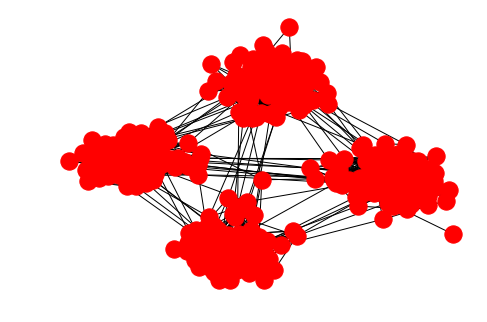

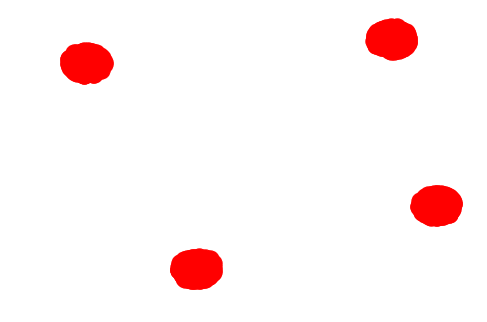

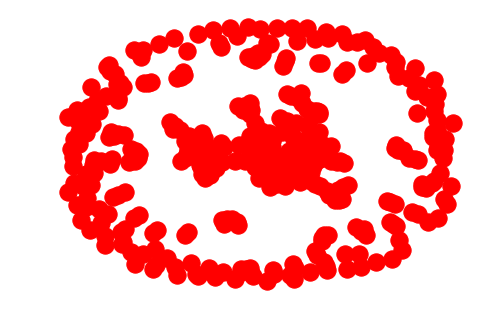

In [2]:
W = generate_random_graph()
network = nx.from_numpy_array(W)
nx.draw(network)

W = generate_random_graph(p=1, q=0)
network = nx.from_numpy_array(W)
plt.figure()
nx.draw(network)

W = generate_random_graph(p=.01, q=.001)
network = nx.from_numpy_array(W)
plt.figure()
nx.draw(network)

Obviously, the bigger $\frac{p}{q}$, the more communities are isolated

# 2. Label Propagation

In [3]:
#slide 10/33
import collections
def label_propagation(W):
    labels = np.arange(W.shape[0])
    condition = True
    while condition:
        condition = False
        shuffled_nodes = np.random.permutation(np.arange(start=0, stop=W.shape[0]))
        for node in shuffled_nodes:
            neighbours = np.unique(np.concatenate( (np.where(W[node,:] > 0 )[0], np.where(W[:, node] > 0 )[0]) ))
            if len(neighbours)>0:
                neighbours_labels = list(labels[neighbours])
                most_frequent_label = sorted(neighbours_labels, key = neighbours_labels.count, reverse=True)[0]
                if labels[node] != most_frequent_label:
                    condition = True
                    labels[node] = most_frequent_label
    return labels

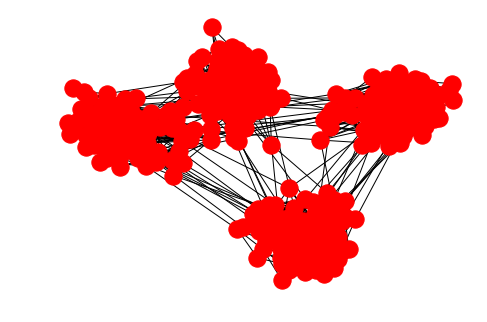

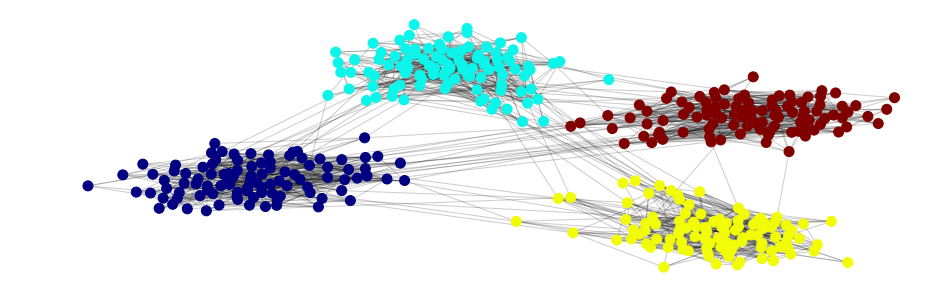

In [4]:
# running the algorithm
W = generate_random_graph(nb_nodes=400, nb_clusters=4, p=.1, q=.001)
labels = label_propagation(W)

# drawing the network with a different color per label
g = nx.from_numpy_array(W)
nx.draw(g)
plt.figure(figsize=(16,5))
plt.axis('off')
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=g.nodes(), node_color=labels, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

# 3. Custom community detection

Let us implement the Girvan-Newman algorithm. This is a divise approach: We start from the entire graph, and iteratively remove the edge with the edges with the highest betweenness until no edges remain.

The output is a dendrogram of graphs. We iterate through the split, and compute modularity at each step. When it stops increasing, we consider the algorithm over.

## 3.1 Modularity Function

As defined in class

In [5]:
# Computing modularity
# Adapted from https://github.com/GiulioRossetti/partition_quality/blob/master/pquality/PartitionQuality.py

def modularity(g, coms):
    """
    g: networkx graph
    coms: a partition of the graph: list of list of nodes.
    
    outputs the sum of the modularities of each community. 
    """
    ######## Process the list of communities into a dictionnary (key=node_id, value=community_id)
    part = {} # a dictionnary: keys are nodes, and values are community indices
    ids = 0
    for c in coms:
        for n in c:
            part[n] = ids
        ids += 1

    ######## Counting the degree, and the neighbours belonging to the same community for each node
    inc = dict([]) # number of half edges belonging to the same community.
    deg = dict([])
    links = g.size(weight='weight')

    for node in g:
        try:
            com = part[node]
            deg[com] = deg.get(com, 0.) + g.degree(node, weight='weight')
            for neighbor, dt in g[node].items():
                if part[neighbor] == com:
                    if neighbor == node:
                        inc[com] = inc.get(com, 0.) + 1.
                    else:
                        inc[com] = inc.get(com, 0.) + .5
        except:
            pass

    ######## Computing and Summing the modularity of all communities
    mod = 0.
    for com in set(part.values()):
        mod += (inc.get(com, 0.) / links) - (deg.get(com, 0.) / (2.*links))**2
    
    return mod

## 3.2 Girwan-Newman algorithm

Adapted from the Networkx package.

In [6]:
# Adapted from https://networkx.github.io/documentation/latest/_modules/networkx/algorithms/community/centrality.html#girvan_newman
# The code for betweenness centrality can be found here: https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/centrality/betweenness.html#betweenness_centrality
def most_valuable_edge(g):
    """
    returns the edge with the highest betweenness centrality in the networkx graph g.
    """
    betweenness = nx.edge_betweenness_centrality(g)
    return max(betweenness, key=betweenness.get)

def _without_most_central_edges(g, most_valuable_edge):
    """
    returns the connected components of the graph that results from
    repeatedly removing the most "valuable" edge in the graph.
    """
    original_num_components = nx.number_connected_components(g)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(g)
        g.remove_edge(*edge)
        new_components = tuple(nx.connected_components(g))
        num_new_components = len(new_components)
    return new_components

def girvan_newman_generator(G):
    """
    Finds communities in a graph using the Girvan–Newman method.
    G: networkx graph
    
    outputs an iterator over tuples of sets of nodes in `G`. Each set of node 
    is a community, each tuple is a sequence of communities at a
    particular level of the algorithm.
    """
    #NB: we use yield instead of "return". This creates a generaor, and we can iterate trhough it to get to
    #the step of the dendrogram we like without running it all at once in one shot.
    g = G.copy()
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)

import itertools
def girvan_newman(W):
    """
    W: adjacency matrix of a grapg
    
    outputs communities: a list of list of nodes.
    """
    #Create networkx graph
    g = nx.from_numpy_array(W).to_undirected()
    
    # Create the Girvan-newman generator
    community_generator = girvan_newman_generator(g)
    nb_communities_max = 10 #maximum iterations we will go through.
    splits = itertools.takewhile(lambda c: len(c) <= nb_communities_max, community_generator)
    
    # For each split, we compute the modularity until it decreases
    best_partition = []
    best_modularity = 0
    for partition in splits:
        mod = modularity(g, partition)
        if mod > best_modularity:
            best_modularity = mod
            best_partition = partition
            print("found a better partion with {} communities and modularity={:6.4f}".format(len(best_partition), best_modularity))
        else:
            print("modularity decreased to {:6.4f}.\n STOP".format(mod))
            break

    # Sorting the communities obtained.
    communities = [sorted(community) for community in best_partition]
    return communities

## 3.3 Evaluation

Let us iterate through the generator provided by ```girvan_newman()``` until the modularity score starts decreasing.

found a better partion with 2 communities and modularity=0.3641
found a better partion with 3 communities and modularity=0.5998
found a better partion with 4 communities and modularity=0.7181
modularity decreased to 0.7174.
 STOP


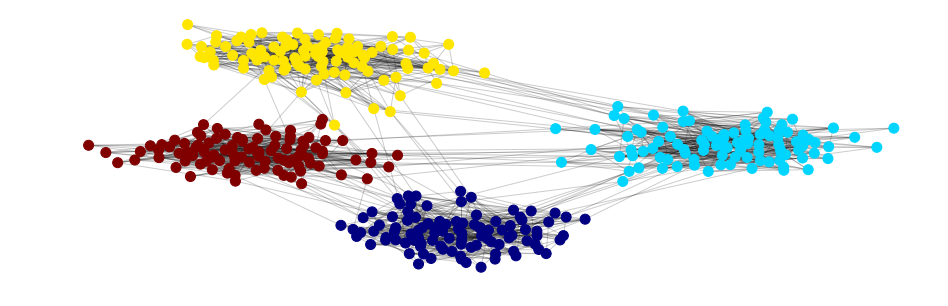

In [7]:
communities = girvan_newman(W)

# Drawing the communities obtained.
gn_labels = np.zeros(len(g.nodes))
for index in range(len(communities)):
    gn_labels[communities[index]] = index
pos = nx.spring_layout(g)
plt.figure(figsize=(16,5))
plt.axis('off')
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=g.nodes(), node_color=list(gn_labels), 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)

We obtain a very similar clustering.

# 4. Benchmark

Let us time several algorithms (Label Propagation, Girwan-Newman, and Louvain Algorithm) for 3 different graphs (with exponential growth).

In [15]:
nb_nodes_array = [400, 1000]

from time import time
def time_it(fun, fun_name, W, monitor):
    start = time()
    fun(W)
    delay = time() - start
    return monitor.append({'function' : fun_name, 'nb_nodes': W.shape[0], 'time' : delay} , ignore_index=True)

import pandas as pd
monitor = pd.DataFrame( columns = ['function', 'nb_nodes', 'time'])

import community
for index in range(len(nb_nodes_array)):
    print("=============================================================")
    W = generate_random_graph(nb_nodes=nb_nodes_array[index], nb_clusters=4, p=.1, q=.001)
    
    ############## Label Propagation
    print("Computing label propagation for {} nodes".format(nb_nodes_array[index]))
    monitor = time_it(label_propagation, "label_propagation", W, monitor)
    
    ############## Louvain
    print("Computing louvain for {} nodes".format(nb_nodes_array[index]))
    monitor = time_it(lambda w: community.best_partition(nx.from_numpy_array(w)), "louvain", W, monitor)
    
    ############## Girwan Newman
    print("Computing girvan_newman for {} nodes".format(nb_nodes_array[index]))
    monitor = time_it(girvan_newman, "girvan_newman", W, monitor)

Computing label propagation for 400 nodes
Computing louvain for 400 nodes
Computing girvan_newman for 400 nodes
found a better partion with 2 communities and modularity=0.3867
found a better partion with 3 communities and modularity=0.6075
found a better partion with 4 communities and modularity=0.7212
modularity decreased to 0.7205.
 STOP
Computing label propagation for 1000 nodes
Computing louvain for 1000 nodes
Computing girvan_newman for 1000 nodes
found a better partion with 2 communities and modularity=0.3676
found a better partion with 3 communities and modularity=0.6070
found a better partion with 4 communities and modularity=0.7233
modularity decreased to 0.7227.
 STOP


In [17]:
nb_nodes_array = [10000]
for index in range(len(nb_nodes_array)):
    print("=============================================================")
    W = generate_random_graph(nb_nodes=nb_nodes_array[index], nb_clusters=4, p=.1, q=.001)
    
    ############## Label Propagation
    print("Computing label propagation for {} nodes".format(nb_nodes_array[index]))
    monitor = time_it(label_propagation, "label_propagation", W, monitor)
    
    ############## Louvain
    print("Computing louvain for {} nodes".format(nb_nodes_array[index]))
    monitor = time_it(lambda w: community.best_partition(nx.from_numpy_array(w)), "louvain", W, monitor)
    
monitor

Computing label propagation for 10000 nodes
Computing louvain for 10000 nodes


,function,nb_nodes,time
0,label_propagation,400,0.074895
1,louvain,400,0.168146
2,girvan_newman,400,29.888947
3,label_propagation,1000,0.127472
4,louvain,1000,0.476656
5,girvan_newman,1000,37206.545481
6,label_propagation,10000,33.205727
7,louvain,10000,20.225408


The algorithm which performs best scaling up is Louvain's community detection.

The memory size is big only for our implementation of girvan_newman: up to 4Go of memory. Obviously using C could have been beneficial for its implementation.